In [1]:
#Using FastAI Library for Image Classification
#Classifying Balls (Basketball, Soccerball, Football)
#Based on fastai course-v3

In [2]:
from fastai import *
from fastai.vision import *

In [12]:
folder = 'basketball'
file = 'urls_basketball.csv'

In [15]:
folder = 'soccerball'
file = 'urls_soccerball.csv'

In [18]:
folder = 'football'
file = 'urls_football.csv'

In [19]:
path = Path('data/balls')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [7]:
path.ls()

[PosixPath('data/balls/urls_soccerball.csv'),
 PosixPath('data/balls/soccerball'),
 PosixPath('data/balls/football'),
 PosixPath('data/balls/urls_basketball.csv'),
 PosixPath('data/balls/basketball'),
 PosixPath('data/balls/urls_football.csv')]

In [8]:
classes = ['basketball','soccerball','football']

In [20]:
download_images(path/file, dest, max_pics=200)

In [21]:
#Removing images that can't be opened
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

In [22]:
np.random.seed(20)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [23]:
data.classes

['basketball', 'football', 'soccerball']

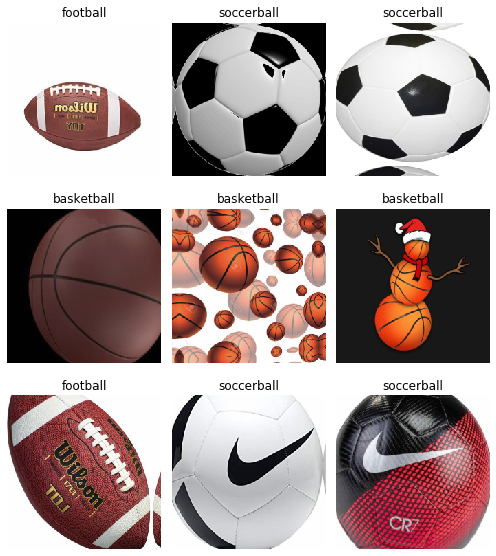

In [26]:
data.show_batch(rows=3, figsize=(7,8))

In [27]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['basketball', 'football', 'soccerball'], 3, 228, 57)

In [28]:
#Training the model
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [29]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.934600,0.665836,0.263158,00:07
1,1.192731,1.075949,0.263158,00:03
2,0.831339,1.092987,0.228070,00:03
3,0.675047,0.946784,0.210526,00:03


In [30]:
learn.save('stage-1')

In [31]:
learn.unfreeze()

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


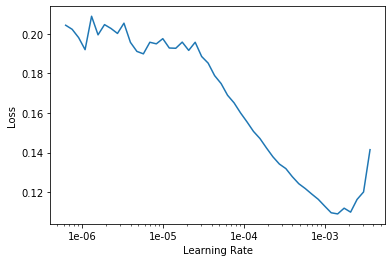

In [35]:
learn.recorder.plot()